# Защита персональных данных клиентов

**Описание проекта**

Нужно защитить данные клиентов страховой компании «Хоть потоп». Разработать метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

**Цель проекта:** Разработать алгоритм для защиты данных клиентов страховой компании без потери качества линейной регрессии.

**Описание данных**

Набор данных находится в файле /datasets/insurance.csv.

**Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи. 

**Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

## Загрузка данных

Импортируем все необходимые библиотеки и структуры. Загрузим и изучим данные.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from numpy.linalg import inv
from sklearn.model_selection import train_test_split

--2023-03-06 03:22:18--  https://code.s3.yandex.net/datasets/insurance.csv
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95668 (93K) [application/octet-stream]
Saving to: ‘insurance.csv.2’

insurance.csv.2     100%[===================>]  93.43K   225KB/s    in 0.4s    

2023-03-06 03:22:20 (225 KB/s) - ‘insurance.csv.2’ saved [95668/95668]



In [3]:
insurance = pd.read_csv('insurance.csv')

In [4]:
print('Общая информация о данных')
print()
insurance.info()
print()
print('Числовое описание данных')
print(insurance.describe())
print()
print('Наличие пропусков')
print(insurance.isnull().sum())
print()
print('Наличие дубликатов')
print(insurance.duplicated().sum())
print()
print('Представление данных')
display(insurance)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB

Числовое описание данных
               Пол      Возраст      Зарплата  Члены семьи  Страховые выплаты
count  5000.000000  5000.000000   5000.000000  5000.000000        5000.000000
mean      0.499000    30.952800  39916.360000     1.194200           0.148000
std       0.500049     8.440807   9900.083569     1.091387           0.463183
min       0.000000    18.000000   5300.000000     0.000000           0.000000
25%       0.000000    24.000000  33300.000000     0.000000     

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [5]:
insurance_cor = insurance.drop('Пол', axis=1)

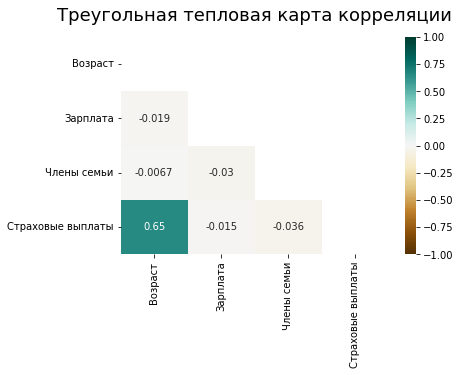

In [6]:
mask = np.triu(np.ones_like(insurance_cor.corr(), dtype=bool)) 
heatmap = sns.heatmap(insurance_cor.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Треугольная тепловая карта корреляции', fontdict={'fontsize':18}, pad=16);

<AxesSubplot:xlabel='count', ylabel='Пол'>

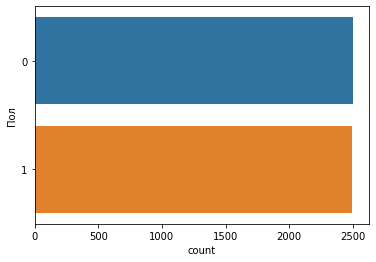

In [7]:
sns.countplot(y='Пол', data=insurance)

<AxesSubplot:xlabel='Возраст', ylabel='Count'>

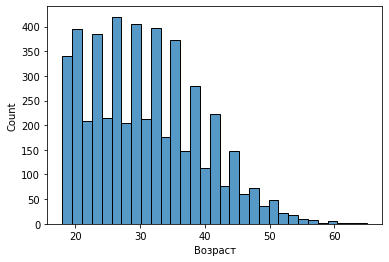

In [8]:
sns.histplot(insurance['Возраст'])

<AxesSubplot:xlabel='Зарплата', ylabel='Count'>

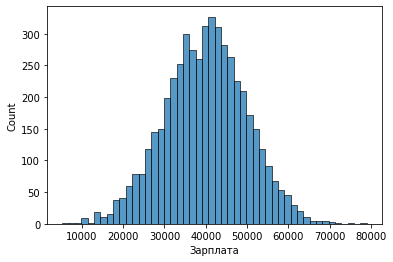

In [9]:
sns.histplot(insurance['Зарплата'])

<AxesSubplot:xlabel='Члены семьи', ylabel='Count'>

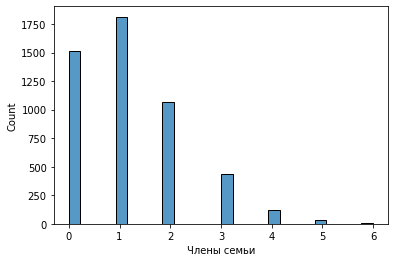

In [10]:
sns.histplot(insurance['Члены семьи'])

<AxesSubplot:xlabel='Страховые выплаты', ylabel='Count'>

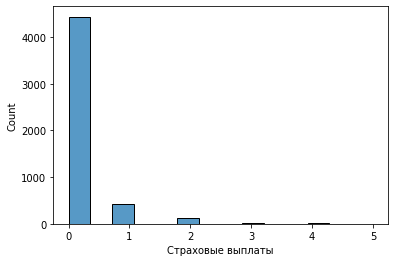

In [11]:
sns.histplot(insurance['Страховые выплаты'])

**Вывод** 

1. Перед нами DataFrame в предобработанном виде.
2. Тип данных в колонках 'Возраст' и 'Зарплата' - float64, в остальных - int64.
3. В DataFrame есть дубликаты, но удалять не будем, поскольку возможно это реальные данные (совпадения).
4. Пропусков нет.
5. Признаки распределены без аномалий.

## Умножение матриц

Перейдем к обучению модели линейной регрессии. 

Выделим features и target.
Сначала обучим модель на исходных данных, после умножим features на обратимую матрицу и снова обучим модель линейной регрессии.

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

In [12]:
features = insurance.drop('Страховые выплаты', axis=1)
target = insurance['Страховые выплаты']

Создадим класс LinearRegression и напишем функцию с методами fit и predict.
Первый метод будет находить вектор весов линейной регрессии, а второй делать предсказания.

In [13]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        print(w)

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

Обучим модель, сохраним предсказания, посмотрим на вектор весов линейной регрессии и значение метрики R2. R2 вычисляется по MSE.

In [14]:
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('R2:', r2_score(target, predictions))

[-9.38235504e-01  7.92580543e-03  3.57083050e-02 -1.70080492e-07
 -1.35676623e-02]
R2: 0.4249455028666801


Для дальнейших операций с features, переведем их в вектор.
Создадим случайную квадратную матрицу, размером по количеству столбцов features и проверим ее на обратимость методом np.linalg.inv.

In [15]:
matrix = features.values

In [16]:
random_matrix = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
random_matrix

array([[ 0.10275577,  0.04027003,  0.41912327,  0.37815046],
       [-0.61855224,  0.56047961, -1.32800106,  0.69768906],
       [-1.33188302, -0.14149041,  0.12216965,  0.01180015],
       [-1.77883436,  0.53561365, -0.65544459,  1.15351335]])

In [17]:
invert_matrix = np.linalg.inv(random_matrix)
invert_matrix

array([[  1.39582377,   0.99331144,   0.31338864,  -1.06158456],
       [-15.2768106 , -12.08233834, -12.18275358,  12.44060728],
       [ -3.19343243,  -3.65344911,  -2.93929053,   3.28670101],
       [  7.4314611 ,   5.06606052,   4.46997302,  -4.67917584]])

Умножим матрицу из features (matrix) на обратимую.

In [18]:
matrix_2 = matrix.dot(random_matrix)
matrix_2

array([[-66088.43455388,  -6994.36855656,   6004.93009483,
           615.4243928 ],
       [-50641.78702914,  -5350.31772675,   4580.70306843,
           481.65293883],
       [-27987.4814525 ,  -2955.0446032 ,   2527.05054287,
           268.0361486 ],
       ...,
       [-45166.76311985,  -4784.2439211 ,   4113.68010135,
           416.28591856],
       [-43571.41667792,  -4612.75859181,   3964.18420227,
           405.05277959],
       [-54093.44618724,  -5728.24114354,   4922.66729135,
           500.15307822]])

Обучим снова модель линейной регрессии и проверим метрику R2.

In [19]:
model = LinearRegression()
model.fit(matrix_2, target)
predictions = model.predict(matrix_2)
print('R2:', r2_score(target, predictions))

[-0.93823642  0.06093631 -0.72131582 -0.20036287  0.30328882]
R2: 0.4249455028661576


**Вопрос:** Изменится ли качество линейной регрессии?   
**Ответ:** Не изменится.

В результате умножения признаков на обратимую матрицу, качество линейной регрессии не изменилось.

**Обоснование:** Качество линейной регрессии не изменилось, поскольку 𝑤 (веса) изменяются под новые (зашифрованные), а все преобразования выражаются через 𝑤 (веса).

## Алгоритм преобразования

In [20]:
def encode(features):
    random_matrix = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
    encoded_features = features.dot(random_matrix)
    return encoded_features

In [21]:
encoded_features = encode(features)
encoded_features

,0,1,2,3
0,44966.870241,-14227.255986,-5373.455808,-111130.479187
1,34442.271723,-10905.206250,-4121.568586,-85141.629801
2,19032.633993,-6027.917295,-2278.359044,-47053.109006
3,37811.237032,-11956.081396,-4514.247272,-93427.910673
4,23658.860612,-7488.977995,-2829.196373,-58478.964681
...,...,...,...,...
4995,32364.720522,-10239.467602,-3868.183799,-79985.418425
4996,47511.204164,-15026.853024,-5673.658436,-117404.004719
4997,30736.461930,-9720.751369,-3671.129569,-75951.842713
4998,29644.914407,-9377.699626,-3543.104952,-73261.164583


In [22]:
def decode(encoded_features):
    decoded_features = encoded_features.dot(np.linalg.inv(random_matrix))
    decoded_features = np.round(decoded_features).astype(int)
    decoded_features.columns = features.columns
    return decoded_features

In [23]:
decoded_features = decode(encoded_features)
decoded_features

,Пол,Возраст,Зарплата,Члены семьи
0,-528589,-326797,-293537,277606
1,-404893,-250302,-224817,212616
2,-223744,-138313,-124228,117486
3,-444461,-274803,-246844,233448
4,-278118,-171937,-154433,146051
...,...,...,...,...
4995,-380454,-235214,-211275,199809
4996,-558485,-345294,-310158,293326
4997,-361305,-223384,-200654,189765
4998,-348482,-215450,-193525,183022


Уравнение для обучения:

$w^* = (X^T X)^{-1}X^Ty$

Уравнение для получения предсказаний:  
$\hat y = \hat X w^*$

где:

- $w^*$ - оптимальные веса признаков (минимизируют квадрат ошибки)
- $X$ - матрица признаков тренировочной выборки (фичи из тренировочной выборки, размерность m x n)
- $y$ - вектор с таргетами (таргет из тренировочной выборки, размерность m x 1)
- $\hat X$ - матрица признаков тестовой выборки (фичи из тренировочной выборки, размерность $\hat m$ x n)
- $\hat y$ - вектор с предсказаниями (размерность $\hat m$ x 1)

1. Уравнение для получения предсказаний на зашифрованных данных:  
$\hat y= X_{test} P_{E}w $   


2. Уравнение для получения параметров линейной регрессии:   
$ w = ((X_{train} P_{E})^T X_{train} P_{E})^{-1} (X_{train} P_{E})^T y_{train}$


3. Подставим уравнение для получения параметров линейной регрессии в уравнение для получения предсказаний:  
$\hat y = X_{test} P_{E}((X_{train} P_{E})^T X_{train} P_{E})^{-1} (X_{train} P_{E})^T y_{train} $


4. Проведем преобразование уравнения с учетом свойства $ (AB)^T = B^TA^T $:  
$\hat y  = X_{test} P_{E}(P_{E}^T X_{train}^T X_{train} P_{E})^{-1} P_{E}^T X_{train}^T y_{train} $


5. Поскольку используем квадратичную матрицу ($X_{train}^T X_{train}$), а также учитывая свойство $ (ABC)^{-1} = C^{-1}B^{-1}A^{-1} $, проведем дальнейшие преобразования уравнения:   
$\hat y = X_{test} P_{E}P_{E}^{-1}(X_{train}^T X_{train})^{-1}(P_{E}^T)^{-1}P_{E}^T X_{train}^T y_{train} $


6. Учитывая свойства единичных матриц $AI = A$, проведем дальнейшие преобразования:    
$\hat y  = X_{test} I (X_{train}^T X_{train})^{-1} I X_{train}^T y_{train} $   


7. В итоге получаем исходную формулу:  
$\hat y  = X_{test} (X_{train}^T X_{train})^{-1} X_{train}^T y_{train} $

## Проверка алгоритма

In [24]:
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('R2:', r2_score(target, predictions))

[-9.38235504e-01  7.92580543e-03  3.57083050e-02 -1.70080492e-07
 -1.35676623e-02]
R2: 0.4249455028666801


In [25]:
model = LinearRegression()
model.fit(encoded_features, target)
predictions = model.predict(encoded_features)
print('R2:', r2_score(target, predictions))

[-0.93824887 -0.26161147  0.16581545  0.19278644 -0.13641917]
R2: 0.4249455024682369


Качество линейной регрессии из sklearn не отличается до и после преобразования.

**Общий вывод**

Предложен алгоритм для защиты данных клиентов страховой компании «Хоть потоп», который позволяет сохранить качество линейной регрессии.

Преимущества разработанного алгоритма:
1. После преобразований качество линейной регрессии не меняется.
2. Возможно расшифровать данные при необходимости
